In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading req

In [2]:
library(ComplexHeatmap)


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheatmap::pheatmap().



Attaching package: 'Co

In [3]:
library(svglite)

Warning message:
"package 'svglite' was built under R version 4.2.3"


In [4]:
library(ggrepel)

In [5]:
source('../src/common_functions.R')

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

# Enrichment of differentially expressed proteins and transcripts

Compare DE genes and DE proteins and run enrichment for all

# Create DE df

# GOSEQ

In [7]:
df_all = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 53457 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): contrast, protein_id, Assay, contrast1, Name, gene, locus_tag, old...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (5): Note, exception, down, up, is_de

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
goseq_res = read_csv(file.path('DE_results', 'HOT1A3_GOSEQ_results_ROS_exoprotease.csv'))

Rows: 256 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): type, PATH, contrast, organism
dbl (5): over_represented_pvalue, padj, under_represented_pvalue, numDEInCat...
lgl (1): category

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
category.order

[1] "Photosynthesis/Carbon fixation"          
 [2] "high light inducible"                    
 [3] "Energy/Carbohydrate/Glycan"              
 [4] "AA/Nucleotide;Energy/Carbohydrate/Glycan"
 [5] "AA/Nucleotide"                           
 [6] "Nitrogen metabolism"                     
 [7] "Metabolism"                              
 [8] "Membrane transport"                      
 [9] "Motility"                                
[10] "Env. Info/Cellular Process"              
[11] "Genetic Info"                            
[12] "Other"                                   
[13] "Uncharacterized"

In [10]:
#goseq_res = goseq_res %>%
#    mutate(Category = factor(Category, levels=category.order))


In [11]:
head(goseq_res)

category,over_represented_pvalue,padj,under_represented_pvalue,numDEInCat,numInCat,type,PATH,contrast,organism
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
TRUE,1.000000e+00,1.000000e+00,0.0000000,3,461,down,is_signal_b,C2vsC1_prot,HOT1A3
TRUE,7.639912e-15,7.639912e-15,1.0000000,91,461,up,is_signal_b,C2vsC1_prot,HOT1A3
TRUE,5.119669e-01,5.119669e-01,0.8496454,1,12,down,ROS_degradation_b,C2vsC1_prot,HOT1A3
TRUE,1.840711e-01,1.840711e-01,0.9604863,2,12,up,ROS_degradation_b,C2vsC1_prot,HOT1A3
TRUE,1.000000e+00,1.000000e+00,0.3802649,0,10,down,Protease_Aminase_b,C2vsC1_prot,HOT1A3
TRUE,7.493730e-01,7.493730e-01,0.6238617,1,10,up,Protease_Aminase_b,C2vsC1_prot,HOT1A3


In [12]:
goseq_meta = goseq_res %>% distinct(contrast) %>% 
    separate_wider_delim(contrast, "_", names = c(NA, "Assay"), cols_remove = FALSE) %>%
    mutate(Group = case_when(
        str_detect(contrast, "C")~ "Coculture", 
        str_detect(contrast, "P3|P5|LATEvsP")~ "Axenic late", 
        TRUE~ "Axenic"
    )) %>% 
    mutate(
        Group = factor(Group, levels=c("Coculture", "Axenic", "Axenic late")),
        Assay = factor(Assay, levels=c("rna", "prot"))
          ) %>%
    arrange(Group, Assay, contrast) %>%
    column_to_rownames('contrast') 
goseq_meta 

,Assay,Group
,<fct>,<fct>
C1vsA1_rna,rna,Coculture
C2vsC1_rna,rna,Coculture
C3vsC1_rna,rna,Coculture
C3vsC2_rna,rna,Coculture
C4vsC1_rna,rna,Coculture
C4vsC3_rna,rna,Coculture
C5vsC1_rna,rna,Coculture
C5vsC4_rna,rna,Coculture
LATEvsC1_rna,rna,Coculture


In [13]:
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 300)

In [14]:
goseq_pal_updown_fun = colorRamp2(c(-6, log10(0.05), 0,-log10(0.05), 6), c('blue', 'lightblue', "white", 'pink', "red"))


In [15]:
goseq_pal_fc_fun = colorRamp2(c(-5,-2,-1, 0, 1,2, 5), rev(RColorBrewer::brewer.pal(7, "BrBG")))
pfcgoseq = goseq_pal_fc_fun(seq(-10, 10, length.out = 20))
#pfcgoseq = goseq_pal_up_fun(c(-5, -2, 0, 2, 5))
#show_col(pfcgoseq)

In [16]:
group_pal = c(Coculture='darkgreen', Axenic='#A6BB8D','Axenic late'='darkred')


In [17]:
coclture_assays = goseq_meta %>% filter(Group == "Coculture") %>% row.names()

In [18]:
df_all %>%
    filter(
        contrast1 %in% coclture_assays
    ) %>%
  mutate(
      padj = if_else(is.na(padj), 1, padj),
      up = if_else(is.na(up), FALSE, up),
      down = if_else(is.na(down), FALSE, down),
      significant = padj < 0.05,
      significant_up = significant & up,
      significant_down = significant & down,
      
  ) %>% 
  group_by(gene_id) %>%
  summarise(
      is_up = any(significant_up),
      is_down = any(significant_down),
      de_gene = is_up | is_down
  ) %>%
  group_by(
      #Assay,
      de_gene, 
      is_up, 
      is_down
  ) %>%
  summarise(number_of_genes = n()) %>%

tail() %>% t()
  
#t(head(df_all))

`summarise()` has grouped output by 'de_gene', 'is_up'. You can override using the `.groups` argument.


de_gene,0,1,1,1
is_up,0,0,1,1
is_down,0,1,0,1
number_of_genes,478,549,451,377


In [19]:
contrast_list_longterm = c(
    'LATEvsC1_prot', 
    'LATEvsC1_rna',
    'A3vsA1_prot', 
    'A3vsA1_rna'
    
)

In [20]:
contrast_list_individual = c(
    "A2vsA1_prot", 
    "A3vsA1_prot",
    "A5vsA1_prot", 
    "A2vsA1_rna", 
    "A3vsA1_rna", 
    
    "A3vsA2_prot", 
    "A5vsA3_prot", 

    "A3vsA2_rna", 
    
    "C2vsC1_prot", 
    "C3vsC1_prot", 
    "C4vsC1_prot", 
    "C5vsC1_prot", 

    "C2vsC1_rna" , 
    "C3vsC1_rna", 
    "C4vsC1_rna", 
    "C5vsC1_rna", 
    
    "C3vsC2_prot", 
    "C4vsC3_prot", 
    "C5vsC4_prot", 

    "C3vsC2_rna", 
    "C4vsC3_rna", 
    "C5vsC4_rna"
    )
comparison_order_inidividual =c("AX\nvs 1st", "AX\nvs prev", "CC\nvs 1st", "CC\nvs prev")


In [21]:
dput(sort(unique(goseq_res$contrast)))


c("A2vsA1_prot", "A2vsA1_rna", "A3vsA1_prot", "A3vsA1_rna", "A3vsA2_prot", 
"A3vsA2_rna", "A5vsA1_prot", "A5vsA3_prot", "C1vsA1_rna", "C2vsC1_prot", 
"C2vsC1_rna", "C3vsC1_prot", "C3vsC1_rna", "C3vsC2_prot", "C3vsC2_rna", 
"C4vsC1_prot", "C4vsC1_rna", "C4vsC3_prot", "C4vsC3_rna", "C5vsC1_prot", 
"C5vsC1_rna", "C5vsC4_prot", "C5vsC4_rna", "LATEvsA1_rna", "LATEvsA2_rna", 
"LATEvsA3_rna", "LATEvsC1_prot", "LATEvsC1_rna", "LATEvsC2_prot", 
"LATEvsC2_rna", "LATEvsC3_prot", "LATEvsC3_rna")


[1] 4
structure(2:1, levels = c("AX\nvs 1st", "Survival\nvs growth"
), class = "factor")
[1] Survival\nvs growth AX\nvs 1st         
Levels: AX\nvs 1st Survival\nvs growth


png 
  2

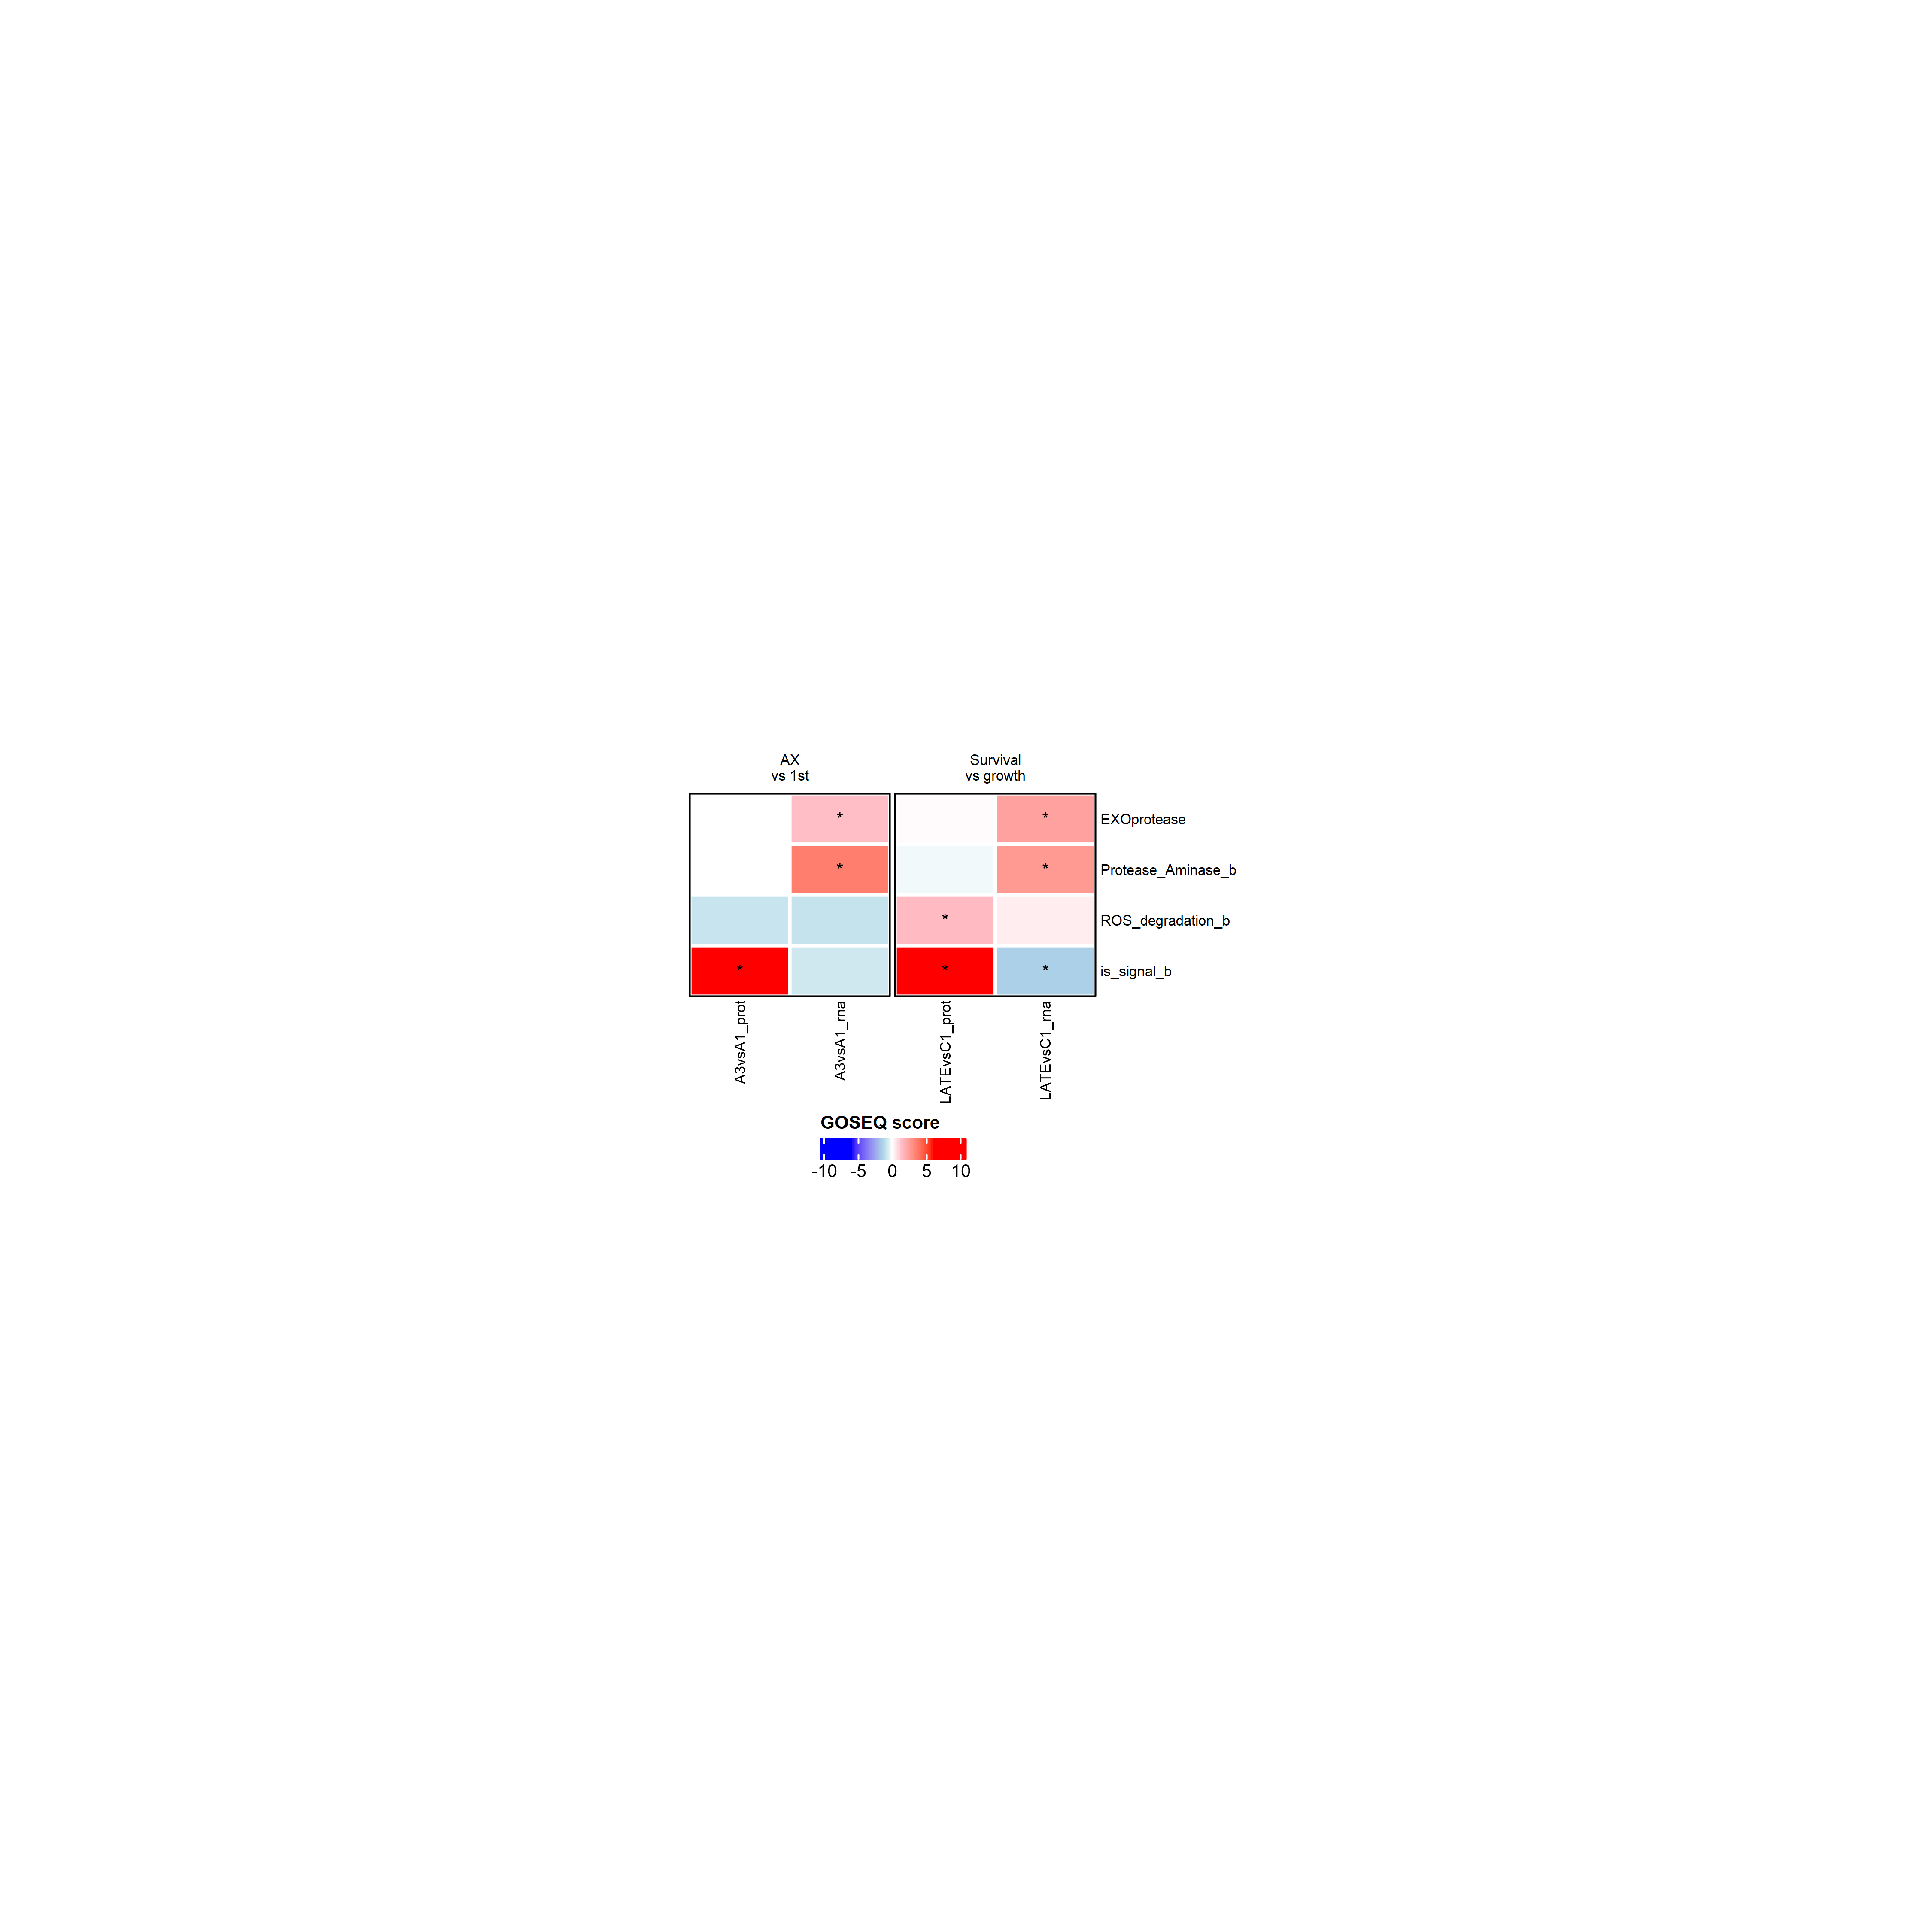

In [22]:
ht = generate_goseq_heatmap_merged_ROS_protease(goseq_res, contrast_map_to_label_alt_continues, contrast_list_longterm)
# Open SVG device
svglite("figures/HOT1A3_goseq_longterm_ROS_protease.svg", width = 10, height = 8)  # dimensions in inches
# Draw the heatmap
draw(ht)
# Close the device
dev.off()
ht

[1] 4
structure(1:4, levels = c("AX\nvs 1st", "AX\nvs prev", "CC\nvs 1st", 
"CC\nvs prev"), class = "factor")
[1] AX\nvs 1st  AX\nvs prev CC\nvs 1st  CC\nvs prev
Levels: AX\nvs 1st AX\nvs prev CC\nvs 1st CC\nvs prev


png 
  2

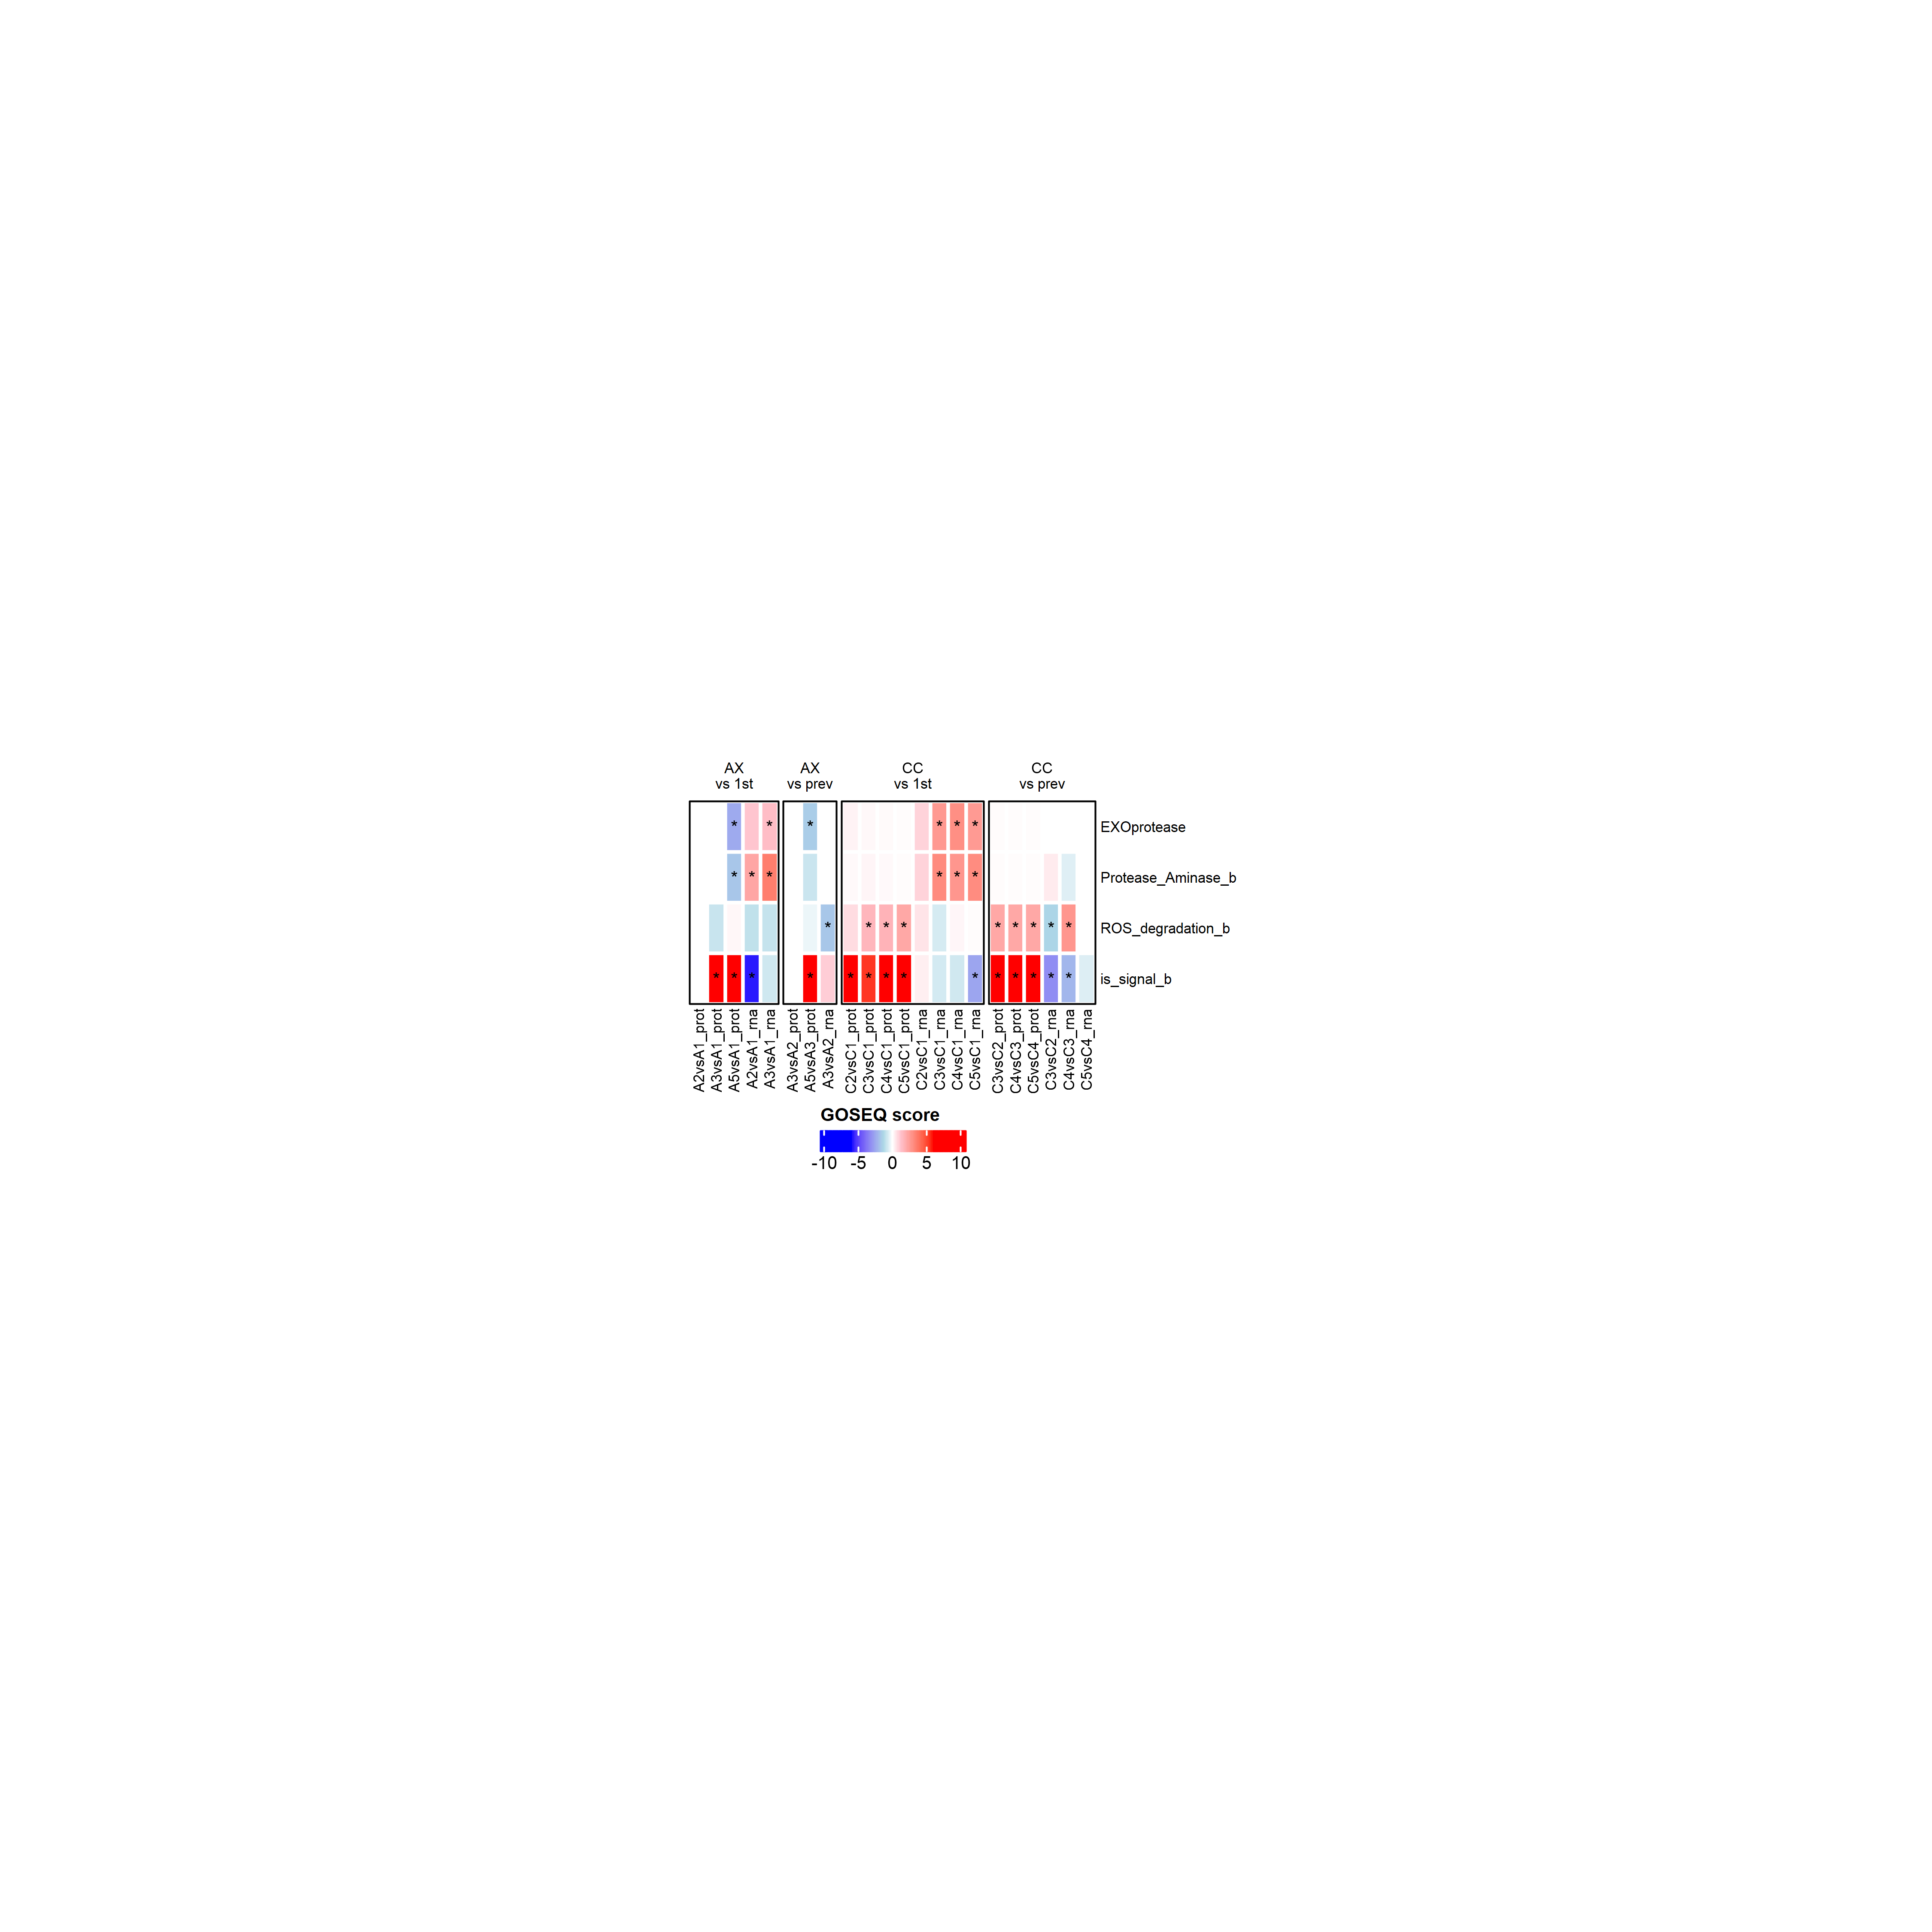

In [23]:
ht = generate_goseq_heatmap_merged_ROS_protease(goseq_res, contrast_map_to_label_alt_continues, contrast_list_individual, comparison_order_inidividual)
# Open SVG device
svglite("figures/HOT1A3_goseq_individual_ROS_protease.svg", width = 10, height = 8)  # dimensions in inches
# Draw the heatmap
draw(ht)
# Close the device
dev.off()
ht

In [24]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 26200)

Matrix products: default

locale:
[1] LC_COLLATE=English_Israel.utf8  LC_CTYPE=English_Israel.utf8   
[3] LC_MONETARY=English_Israel.utf8 LC_NUMERIC=C                   
[5] LC_TIME=English_Israel.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggrepel_0.9.3               svglite_2.1.3              
 [3] ComplexHeatmap_2.14.0       circlize_0.4.15            
 [5] corrplot_0.92               pheatmap_1.0.12            
 [7] lubridate_1.9.2             forcats_1.0.0              
 [9] stringr_1.5.0               dplyr_1.1.0                
[11] purrr_1.0.1                 readr_2.1.4                
[13] tidyr_1.3.0                 tibble_3.1.8               
[15] tidyverse_2.0.0             readxl_1.4.2               
[17] goseq_1.50.0                gen